In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
data = pd.read_csv('PSP_Jan_Feb_2019.csv')

In [3]:
data['tmsp'] = pd.to_datetime(data['tmsp'])

In [4]:
# Calculate the success rate for each PSP grouped by country
success_rate = data.groupby(['country', 'card'])['success'].mean().reset_index()

# Rename the 'success' column to 'success_rate'
success_rate.rename(columns={'success': 'success_rate'}, inplace=True)
data = data.merge(success_rate, on=['country', 'card'], how='left')

data.head()

,tmsp,country,amount,success,PSP,3D_secured,card,success_rate
0,2019-01-01 00:01:11,Germany,89,0,UK_Card,0,Visa,0.208416
1,2019-01-01 00:01:17,Germany,89,1,UK_Card,0,Visa,0.208416
2,2019-01-01 00:02:49,Germany,238,0,UK_Card,1,Diners,0.218723
3,2019-01-01 00:03:13,Germany,238,1,UK_Card,1,Diners,0.218723
4,2019-01-01 00:04:33,Austria,124,0,Simplecard,0,Diners,0.236118


In [5]:
from math import ceil
# Create a new feature 'week_of_month' to extract the week number of the month from the timestamp
def week_of_month(dt):
    first_day = dt.replace(day=1)
    dom = dt.day
    adjusted_dom = dom + first_day.weekday()
    return int(ceil(adjusted_dom/7.0))

data['week_of_month'] = data['tmsp'].apply(week_of_month)

# Display the first few rows to verify the new feature
data.head()

,tmsp,country,amount,success,PSP,3D_secured,card,success_rate,week_of_month
0,2019-01-01 00:01:11,Germany,89,0,UK_Card,0,Visa,0.208416,1
1,2019-01-01 00:01:17,Germany,89,1,UK_Card,0,Visa,0.208416,1
2,2019-01-01 00:02:49,Germany,238,0,UK_Card,1,Diners,0.218723,1
3,2019-01-01 00:03:13,Germany,238,1,UK_Card,1,Diners,0.218723,1
4,2019-01-01 00:04:33,Austria,124,0,Simplecard,0,Diners,0.236118,1


In [6]:
country_success_rate = data.groupby('country')['success'].mean().reset_index()

# Create a new feature 'high_amount' to indicate if the transaction amount is above a certain threshold (e.g., 200)
data['high_amount'] = data['amount'] > 200

# Create a new feature 'hour' to extract the hour of the day from the timestamp
data['hour'] = data['tmsp'].dt.hour

# Display the first few rows to verify the new features
# data.head()
# Create a new feature 'is_weekend' to indicate if the transaction occurred on a weekend
data['is_weekend'] = data['tmsp'].dt.weekday >= 5

# Create a new feature 'is_high_success_country' to indicate if the transaction is from a high success rate country
high_success_countries = country_success_rate[country_success_rate['success'] > 0.2]['country']
data['is_high_success_country'] = data['country'].isin(high_success_countries)

# Display the first few rows to verify the new features
data.head()

,tmsp,country,amount,success,PSP,3D_secured,card,success_rate,week_of_month,high_amount,hour,is_weekend,is_high_success_country
0,2019-01-01 00:01:11,Germany,89,0,UK_Card,0,Visa,0.208416,1,False,0,False,True
1,2019-01-01 00:01:17,Germany,89,1,UK_Card,0,Visa,0.208416,1,False,0,False,True
2,2019-01-01 00:02:49,Germany,238,0,UK_Card,1,Diners,0.218723,1,True,0,False,True
3,2019-01-01 00:03:13,Germany,238,1,UK_Card,1,Diners,0.218723,1,True,0,False,True
4,2019-01-01 00:04:33,Austria,124,0,Simplecard,0,Diners,0.236118,1,False,0,False,True


In [7]:
# Create a new feature 'transaction_hour' to categorize transactions into different time periods of the day
def categorize_hour(hour):
    if 0 <= hour < 6:
        return 'Midnight'
    elif 6 <= hour < 12:
        return 'Morning'
    elif 12 <= hour < 18:
        return 'Afternoon'
    else:
        return 'Evening'

data['transaction_hour'] = data['hour'].apply(categorize_hour)

# Create a new feature 'amount_category' to categorize transaction amounts into different ranges
def categorize_amount(amount):
    if amount < 133:
        return 'Low'
    elif 133 <= amount < 201:
        return 'Medium'
    else:
        return 'High'

data['amount_category'] = data['amount'].apply(categorize_amount)

# Display the first few rows to verify the new features
data.head()

,tmsp,country,amount,success,PSP,3D_secured,card,success_rate,week_of_month,high_amount,hour,is_weekend,is_high_success_country,transaction_hour,amount_category
0,2019-01-01 00:01:11,Germany,89,0,UK_Card,0,Visa,0.208416,1,False,0,False,True,Midnight,Low
1,2019-01-01 00:01:17,Germany,89,1,UK_Card,0,Visa,0.208416,1,False,0,False,True,Midnight,Low
2,2019-01-01 00:02:49,Germany,238,0,UK_Card,1,Diners,0.218723,1,True,0,False,True,Midnight,High
3,2019-01-01 00:03:13,Germany,238,1,UK_Card,1,Diners,0.218723,1,True,0,False,True,Midnight,High
4,2019-01-01 00:04:33,Austria,124,0,Simplecard,0,Diners,0.236118,1,False,0,False,True,Midnight,Low


In [8]:
# Create a 'success_fee' column based on the conditions provided
def calculate_success_fee(row):
    if row['PSP'] == 'Moneycard' and row['success'] == 1:
        return 5
    elif row['PSP'] == 'Goldcard' and row['success'] == 1:
        return 10
    elif row['PSP'] == 'UK_Card' and row['success'] == 1:
        return 3
    elif row['PSP'] == 'Simplecard' and row['success'] == 1:
        return 1
    elif row['PSP'] == 'Moneycard' and row['success'] == 0:
        return 2
    elif row['PSP'] == 'Goldcard' and row['success'] == 0:
        return 5
    elif row['PSP'] == 'UK_Card' and row['success'] == 0:
        return 1
    elif row['PSP'] == 'Simplecard' and row['success'] == 0:
        return 0.5
    else:
        return 0

data['transaction_fee'] = data.apply(calculate_success_fee, axis=1)

# Display the first few rows to verify the new column
data.head()

,tmsp,country,amount,success,PSP,3D_secured,card,success_rate,week_of_month,high_amount,hour,is_weekend,is_high_success_country,transaction_hour,amount_category,transaction_fee
0,2019-01-01 00:01:11,Germany,89,0,UK_Card,0,Visa,0.208416,1,False,0,False,True,Midnight,Low,1.0
1,2019-01-01 00:01:17,Germany,89,1,UK_Card,0,Visa,0.208416,1,False,0,False,True,Midnight,Low,3.0
2,2019-01-01 00:02:49,Germany,238,0,UK_Card,1,Diners,0.218723,1,True,0,False,True,Midnight,High,1.0
3,2019-01-01 00:03:13,Germany,238,1,UK_Card,1,Diners,0.218723,1,True,0,False,True,Midnight,High,3.0
4,2019-01-01 00:04:33,Austria,124,0,Simplecard,0,Diners,0.236118,1,False,0,False,True,Midnight,Low,0.5


In [9]:
data['weekday'] = data['tmsp'].dt.day_name()
data.head()

,tmsp,country,amount,success,PSP,3D_secured,card,success_rate,week_of_month,high_amount,hour,is_weekend,is_high_success_country,transaction_hour,amount_category,transaction_fee,weekday
0,2019-01-01 00:01:11,Germany,89,0,UK_Card,0,Visa,0.208416,1,False,0,False,True,Midnight,Low,1.0,Tuesday
1,2019-01-01 00:01:17,Germany,89,1,UK_Card,0,Visa,0.208416,1,False,0,False,True,Midnight,Low,3.0,Tuesday
2,2019-01-01 00:02:49,Germany,238,0,UK_Card,1,Diners,0.218723,1,True,0,False,True,Midnight,High,1.0,Tuesday
3,2019-01-01 00:03:13,Germany,238,1,UK_Card,1,Diners,0.218723,1,True,0,False,True,Midnight,High,3.0,Tuesday
4,2019-01-01 00:04:33,Austria,124,0,Simplecard,0,Diners,0.236118,1,False,0,False,True,Midnight,Low,0.5,Tuesday


In [10]:
# Calculate the success rate with respect to the 3D secured column for each country
secured_success_rate = data.groupby(['country', 'card','3D_secured'])['success'].mean().reset_index()

# Rename the 'success' column to 'secured_success'
secured_success_rate.rename(columns={'success': 'secured_success_rate_of_card'}, inplace=True)

# Merge the secured_success_rate dataframe with the original data to add the secured_success feature
data = data.merge(secured_success_rate, on=['country', 'card','3D_secured'], how='left')

# Display the updated dataframe
data.head()

,tmsp,country,amount,success,PSP,3D_secured,card,success_rate,week_of_month,high_amount,hour,is_weekend,is_high_success_country,transaction_hour,amount_category,transaction_fee,weekday,secured_success_rate_of_card
0,2019-01-01 00:01:11,Germany,89,0,UK_Card,0,Visa,0.208416,1,False,0,False,True,Midnight,Low,1.0,Tuesday,0.184538
1,2019-01-01 00:01:17,Germany,89,1,UK_Card,0,Visa,0.208416,1,False,0,False,True,Midnight,Low,3.0,Tuesday,0.184538
2,2019-01-01 00:02:49,Germany,238,0,UK_Card,1,Diners,0.218723,1,True,0,False,True,Midnight,High,1.0,Tuesday,0.235252
3,2019-01-01 00:03:13,Germany,238,1,UK_Card,1,Diners,0.218723,1,True,0,False,True,Midnight,High,3.0,Tuesday,0.235252
4,2019-01-01 00:04:33,Austria,124,0,Simplecard,0,Diners,0.236118,1,False,0,False,True,Midnight,Low,0.5,Tuesday,0.236389


In [11]:
# Calculate the success rate for each PSP grouped by country
country_psp_success_rate = data.groupby(['country', 'PSP'])['success'].mean().reset_index()

# Rename the 'success' column to 'country_psp_success_rate'
country_psp_success_rate.rename(columns={'success': 'country_psp_success_rate'}, inplace=True)

# Merge the country_psp_success_rate dataframe with the original data to add the country_psp_success_rate feature
data = data.merge(country_psp_success_rate, on=['country', 'PSP'], how='left')

# Display the updated dataframe
data.head()

,tmsp,country,amount,success,PSP,3D_secured,card,success_rate,week_of_month,high_amount,hour,is_weekend,is_high_success_country,transaction_hour,amount_category,transaction_fee,weekday,secured_success_rate_of_card,country_psp_success_rate
0,2019-01-01 00:01:11,Germany,89,0,UK_Card,0,Visa,0.208416,1,False,0,False,True,Midnight,Low,1.0,Tuesday,0.184538,0.193926
1,2019-01-01 00:01:17,Germany,89,1,UK_Card,0,Visa,0.208416,1,False,0,False,True,Midnight,Low,3.0,Tuesday,0.184538,0.193926
2,2019-01-01 00:02:49,Germany,238,0,UK_Card,1,Diners,0.218723,1,True,0,False,True,Midnight,High,1.0,Tuesday,0.235252,0.193926
3,2019-01-01 00:03:13,Germany,238,1,UK_Card,1,Diners,0.218723,1,True,0,False,True,Midnight,High,3.0,Tuesday,0.235252,0.193926
4,2019-01-01 00:04:33,Austria,124,0,Simplecard,0,Diners,0.236118,1,False,0,False,True,Midnight,Low,0.5,Tuesday,0.236389,0.158658


In [12]:
# Filter the data to get the success rate of UK_Card in Germany
uk_card_germany_successrate = data[(data['PSP'] == 'UK_Card') & (data['country'] == 'Germany')]['success'].mean()

# Add the success rate as a new column to the dataframe
data['uk_card_germany_successrate'] = uk_card_germany_successrate

# Display the updated dataframe to verify the new column
data.head()

,tmsp,country,amount,success,PSP,3D_secured,card,success_rate,week_of_month,high_amount,hour,is_weekend,is_high_success_country,transaction_hour,amount_category,transaction_fee,weekday,secured_success_rate_of_card,country_psp_success_rate,uk_card_germany_successrate
0,2019-01-01 00:01:11,Germany,89,0,UK_Card,0,Visa,0.208416,1,False,0,False,True,Midnight,Low,1.0,Tuesday,0.184538,0.193926,0.193926
1,2019-01-01 00:01:17,Germany,89,1,UK_Card,0,Visa,0.208416,1,False,0,False,True,Midnight,Low,3.0,Tuesday,0.184538,0.193926,0.193926
2,2019-01-01 00:02:49,Germany,238,0,UK_Card,1,Diners,0.218723,1,True,0,False,True,Midnight,High,1.0,Tuesday,0.235252,0.193926,0.193926
3,2019-01-01 00:03:13,Germany,238,1,UK_Card,1,Diners,0.218723,1,True,0,False,True,Midnight,High,3.0,Tuesday,0.235252,0.193926,0.193926
4,2019-01-01 00:04:33,Austria,124,0,Simplecard,0,Diners,0.236118,1,False,0,False,True,Midnight,Low,0.5,Tuesday,0.236389,0.158658,0.193926


In [13]:
# Create a new feature 'uk_card_germany_successrate' based on the condition
uk_card_germany_successrate = data[(data['PSP'] == 'UK_Card') & (data['country'] == 'Germany')]['success'].mean()
data['uk_card_germany_successrate'] = data.apply(
    lambda row: uk_card_germany_successrate if row['country'] == 'Germany' and row['PSP'] == 'UK_Card' else 0, axis=1
)

uk_card_autria_successrate = data[(data['PSP'] == 'UK_Card') & (data['country'] == 'Austria')]['success'].mean()
data['uk_card_Austria_successrate'] = data.apply(
    lambda row: uk_card_germany_successrate if row['country'] == 'Austria' and row['PSP'] == 'UK_Card' else 0, axis=1
)

uk_card_swiz_successrate = data[(data['PSP'] == 'UK_Card') & (data['country'] == 'Switzerland')]['success'].mean()
data['uk_card_swiz_successrate'] = data.apply(
    lambda row: uk_card_germany_successrate if row['country'] == 'Switzerland' and row['PSP'] == 'UK_Card' else 0, axis=1
)

simplecard_germany_successrate = data[(data['PSP'] == 'Simplecard') & (data['country'] == 'Germany')]['success'].mean()
data['simplecard_germany_successrate'] = data.apply(
    lambda row: simplecard_germany_successrate if row['country'] == 'Germany' and row['PSP'] == 'Simplecard' else 0, axis=1
)

simplecard_autria_successrate = data[(data['PSP'] == 'Simplecard') & (data['country'] == 'Austria')]['success'].mean()
data['simplecard_austria_successrate'] = data.apply(
    lambda row: simplecard_autria_successrate if row['country'] == 'Austria' and row['PSP'] == 'Simplecard' else 0, axis=1
)

simplecard_swiz_successrate = data[(data['PSP'] == 'Simplecard') & (data['country'] == 'Switzerland')]['success'].mean()
data['simplecard_swiz_successrate'] = data.apply(
    lambda row: simplecard_swiz_successrate if row['country'] == 'Switzerland' and row['PSP'] == 'Simplecard' else 0, axis=1
)

moneycard_germany_successrate = data[(data['PSP'] == 'Moneycard') & (data['country'] == 'Germany')]['success'].mean()
data['moneycard_germany_successrate'] = data.apply(
    lambda row: moneycard_germany_successrate if row['country'] == 'Germany' and row['PSP'] == 'Moneycard' else 0, axis=1
)

moneycard_autria_successrate = data[(data['PSP'] == 'Moneycard') & (data['country'] == 'Austria')]['success'].mean()
data['moneycard_Austria_successrate'] = data.apply(
    lambda row: moneycard_autria_successrate if row['country'] == 'Austria' and row['PSP'] == 'Moneycard' else 0, axis=1
)

moneycard_swiz_successrate = data[(data['PSP'] == 'Moneycard') & (data['country'] == 'Switzerland')]['success'].mean()
data['moneycard_swiz_successrate'] = data.apply(
    lambda row: moneycard_swiz_successrate if row['country'] == 'Switzerland' and row['PSP'] == 'Moneycard' else 0, axis=1
)

goldcard_germany_successrate = data[(data['PSP'] == 'Goldcard') & (data['country'] == 'Germany')]['success'].mean()
data['moneycard_germany_successrate'] = data.apply(
    lambda row: goldcard_germany_successrate if row['country'] == 'Germany' and row['PSP'] == 'Goldcard' else 0, axis=1
)

goldcard_autria_successrate = data[(data['PSP'] == 'Goldcard') & (data['country'] == 'Austria')]['success'].mean()
data['moneycard_Austria_successrate'] = data.apply(
    lambda row: goldcard_autria_successrate if row['country'] == 'Austria' and row['PSP'] == 'Goldcard' else 0, axis=1
)

goldcard_swiz_successrate = data[(data['PSP'] == 'Goldcard') & (data['country'] == 'Switzerland')]['success'].mean()
data['moneycard_swiz_successrate'] = data.apply(
    lambda row: goldcard_swiz_successrate if row['country'] == 'Switzerland' and row['PSP'] == 'Goldcard' else 0, axis=1
)

data.head()

,tmsp,country,amount,success,PSP,3D_secured,card,success_rate,week_of_month,high_amount,...,country_psp_success_rate,uk_card_germany_successrate,uk_card_Austria_successrate,uk_card_swiz_successrate,simplecard_germany_successrate,simplecard_austria_successrate,simplecard_swiz_successrate,moneycard_germany_successrate,moneycard_Austria_successrate,moneycard_swiz_successrate
0,2019-01-01 00:01:11,Germany,89,0,UK_Card,0,Visa,0.208416,1,False,...,0.193926,0.193926,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0
1,2019-01-01 00:01:17,Germany,89,1,UK_Card,0,Visa,0.208416,1,False,...,0.193926,0.193926,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0
2,2019-01-01 00:02:49,Germany,238,0,UK_Card,1,Diners,0.218723,1,True,...,0.193926,0.193926,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0
3,2019-01-01 00:03:13,Germany,238,1,UK_Card,1,Diners,0.218723,1,True,...,0.193926,0.193926,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0
4,2019-01-01 00:04:33,Austria,124,0,Simplecard,0,Diners,0.236118,1,False,...,0.158658,0.000000,0.0,0.0,0.0,0.158658,0.0,0.0,0.0,0.0


In [14]:
# Calculate the success rate with respect to the 3D secured column for each PSP
psp_secured_success_rate = data.groupby(['3D_secured'])['success'].mean().reset_index()

# Rename the 'success' column to 'psp_secured_success_rate'
psp_secured_success_rate.rename(columns={'success': 'secured_success_rate'}, inplace=True)

# Merge the psp_secured_success_rate dataframe with the original data to add the psp_secured_success_rate feature
data = data.merge(psp_secured_success_rate, on=['3D_secured'], how='left')

# Display the updated dataframe
data.head()

,tmsp,country,amount,success,PSP,3D_secured,card,success_rate,week_of_month,high_amount,...,uk_card_germany_successrate,uk_card_Austria_successrate,uk_card_swiz_successrate,simplecard_germany_successrate,simplecard_austria_successrate,simplecard_swiz_successrate,moneycard_germany_successrate,moneycard_Austria_successrate,moneycard_swiz_successrate,secured_success_rate
0,2019-01-01 00:01:11,Germany,89,0,UK_Card,0,Visa,0.208416,1,False,...,0.193926,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.189562
1,2019-01-01 00:01:17,Germany,89,1,UK_Card,0,Visa,0.208416,1,False,...,0.193926,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.189562
2,2019-01-01 00:02:49,Germany,238,0,UK_Card,1,Diners,0.218723,1,True,...,0.193926,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.245525
3,2019-01-01 00:03:13,Germany,238,1,UK_Card,1,Diners,0.218723,1,True,...,0.193926,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.245525
4,2019-01-01 00:04:33,Austria,124,0,Simplecard,0,Diners,0.236118,1,False,...,0.000000,0.0,0.0,0.0,0.158658,0.0,0.0,0.0,0.0,0.189562


In [15]:
data.shape

(50410, 29)

In [26]:
data_copy = data.copy()

In [27]:
data_copy.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50410 entries, 0 to 50409
Data columns (total 29 columns):
 #   Column                          Non-Null Count  Dtype         
---  ------                          --------------  -----         
 0   tmsp                            50410 non-null  datetime64[ns]
 1   country                         50410 non-null  object        
 2   amount                          50410 non-null  int64         
 3   success                         50410 non-null  int64         
 4   PSP                             50410 non-null  object        
 5   3D_secured                      50410 non-null  int64         
 6   card                            50410 non-null  object        
 7   success_rate                    50410 non-null  float64       
 8   week_of_month                   50410 non-null  int64         
 9   high_amount                     50410 non-null  bool          
 10  hour                            50410 non-null  int32         
 11  is

In [28]:
# Convert boolean columns to categorical
bool_cols = data_copy.select_dtypes(include=['bool']).columns
data_copy[bool_cols] = data_copy[bool_cols].astype('object')

# Display the first few rows to verify the changes
data_copy.head()

,tmsp,country,amount,success,PSP,3D_secured,card,success_rate,week_of_month,high_amount,...,uk_card_germany_successrate,uk_card_Austria_successrate,uk_card_swiz_successrate,simplecard_germany_successrate,simplecard_austria_successrate,simplecard_swiz_successrate,moneycard_germany_successrate,moneycard_Austria_successrate,moneycard_swiz_successrate,secured_success_rate
0,2019-01-01 00:01:11,Germany,89,0,UK_Card,0,Visa,0.208416,1,False,...,0.193926,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.189562
1,2019-01-01 00:01:17,Germany,89,1,UK_Card,0,Visa,0.208416,1,False,...,0.193926,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.189562
2,2019-01-01 00:02:49,Germany,238,0,UK_Card,1,Diners,0.218723,1,True,...,0.193926,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.245525
3,2019-01-01 00:03:13,Germany,238,1,UK_Card,1,Diners,0.218723,1,True,...,0.193926,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.245525
4,2019-01-01 00:04:33,Austria,124,0,Simplecard,0,Diners,0.236118,1,False,...,0.000000,0.0,0.0,0.0,0.158658,0.0,0.0,0.0,0.0,0.189562


In [29]:
data_copy.info()   

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50410 entries, 0 to 50409
Data columns (total 29 columns):
 #   Column                          Non-Null Count  Dtype         
---  ------                          --------------  -----         
 0   tmsp                            50410 non-null  datetime64[ns]
 1   country                         50410 non-null  object        
 2   amount                          50410 non-null  int64         
 3   success                         50410 non-null  int64         
 4   PSP                             50410 non-null  object        
 5   3D_secured                      50410 non-null  int64         
 6   card                            50410 non-null  object        
 7   success_rate                    50410 non-null  float64       
 8   week_of_month                   50410 non-null  int64         
 9   high_amount                     50410 non-null  object        
 10  hour                            50410 non-null  int32         
 11  is

In [30]:
from sklearn.preprocessing import LabelEncoder

# Get the categorical columns
categorical_cols = data_copy.select_dtypes(include=['object']).columns

print(categorical_cols)
# Initialize the LabelEncoder
label_encoder = LabelEncoder()

# Apply label encoding to each categorical column
for col in categorical_cols:
    data_copy[col] = label_encoder.fit_transform(data_copy[col])

# Display the first few rows to verify the changes
data_copy.head()

Index(['country', 'PSP', 'card', 'high_amount', 'is_weekend',
       'is_high_success_country', 'transaction_hour', 'amount_category',
       'weekday'],
      dtype='object')


,tmsp,country,amount,success,PSP,3D_secured,card,success_rate,week_of_month,high_amount,...,uk_card_germany_successrate,uk_card_Austria_successrate,uk_card_swiz_successrate,simplecard_germany_successrate,simplecard_austria_successrate,simplecard_swiz_successrate,moneycard_germany_successrate,moneycard_Austria_successrate,moneycard_swiz_successrate,secured_success_rate
0,2019-01-01 00:01:11,1,89,0,3,0,2,0.208416,1,0,...,0.193926,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.189562
1,2019-01-01 00:01:17,1,89,1,3,0,2,0.208416,1,0,...,0.193926,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.189562
2,2019-01-01 00:02:49,1,238,0,3,1,0,0.218723,1,1,...,0.193926,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.245525
3,2019-01-01 00:03:13,1,238,1,3,1,0,0.218723,1,1,...,0.193926,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.245525
4,2019-01-01 00:04:33,0,124,0,2,0,0,0.236118,1,0,...,0.000000,0.0,0.0,0.0,0.158658,0.0,0.0,0.0,0.0,0.189562


In [31]:
data_copy.shape

(50410, 29)

In [32]:
data_copy.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50410 entries, 0 to 50409
Data columns (total 29 columns):
 #   Column                          Non-Null Count  Dtype         
---  ------                          --------------  -----         
 0   tmsp                            50410 non-null  datetime64[ns]
 1   country                         50410 non-null  int32         
 2   amount                          50410 non-null  int64         
 3   success                         50410 non-null  int64         
 4   PSP                             50410 non-null  int32         
 5   3D_secured                      50410 non-null  int64         
 6   card                            50410 non-null  int32         
 7   success_rate                    50410 non-null  float64       
 8   week_of_month                   50410 non-null  int64         
 9   high_amount                     50410 non-null  int32         
 10  hour                            50410 non-null  int32         
 11  is

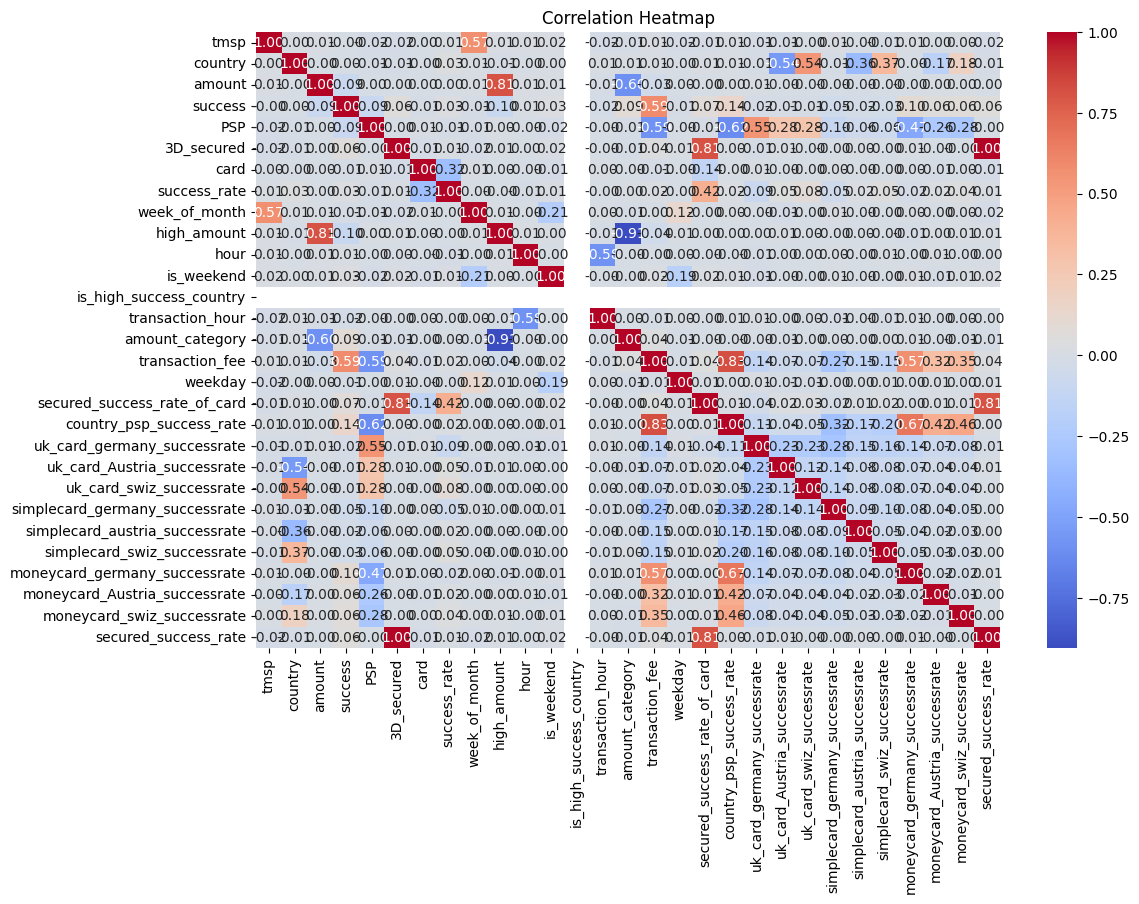

In [33]:
# Calculate the correlation matrix
corr_matrix = data_copy.corr()

# Plot the heatmap
plt.figure(figsize=(12, 8))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Correlation Heatmap')
plt.show()

In [37]:
# Calculate the variance of each column in the data_copy dataframe
variance = data_copy.drop('tmsp', axis =1).var()

# Print the variance of each column
print(variance)

country                              0.400168
amount                            9268.823668
success                              0.161733
PSP                                  0.889743
3D_secured                           0.181499
card                                 0.423307
success_rate                         0.000151
week_of_month                        1.704473
high_amount                          0.250002
hour                                47.893837
is_weekend                           0.176660
is_high_success_country              0.000000
transaction_hour                     1.250254
amount_category                      0.689581
transaction_fee                      3.290782
weekday                              4.213941
secured_success_rate_of_card         0.000860
country_psp_success_rate             0.003230
uk_card_germany_successrate          0.008121
uk_card_Austria_successrate          0.003472
uk_card_swiz_successrate             0.003578
simplecard_germany_successrate    

In [ ]:
# Initialize the model
model = RandomForestClassifier(n_estimators=100, random_state=42)

# Fit the model
model.fit(X, y)

# Get feature importances from the model
feature_importances = model.feature_importances_

# Create a DataFrame for feature importances
feature_importance_df = pd.DataFrame({
    'Feature': X.columns,
    'Importance': feature_importances
}).sort_values(by='Importance', ascending=False)

print("Sorted DataFrame with Feature Importance:")
print(feature_importance_df)

In [69]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import RFE

# Initialize the model
model = RandomForestClassifier(n_estimators=100, random_state=42)

# Initialize RFE with the model and the number of features to select
rfe = RFE(model, n_features_to_select=10)

# Fit RFE
X = data_copy.drop(columns=['PSP', 'tmsp', 'success','transaction_fee'])  # Features
y = data_copy['PSP']  # Target variable
rfe = rfe.fit(X, y)

# Get the ranking of the features
ranking = rfe.ranking_

# Get the support (selected features)
selected_features = X.columns[rfe.support_]

# Get feature importances from the model
feature_importances = model.fit(X[selected_features], y).feature_importances_

# Create a DataFrame for feature importances
feature_importance_df = pd.DataFrame({
    'Feature': selected_features,
    'Importance': feature_importances
}).sort_values(by='Importance', ascending=False)

print("Sorted DataFrame with Feature Importance:")
print(feature_importance_df)

Sorted DataFrame with Feature Importance:
                          Feature  Importance
1        country_psp_success_rate    0.544364
2     uk_card_germany_successrate    0.128463
5  simplecard_germany_successrate    0.089331
3     uk_card_Austria_successrate    0.051957
8   moneycard_germany_successrate    0.046645
4        uk_card_swiz_successrate    0.039902
7     simplecard_swiz_successrate    0.029527
0                         country    0.029046
6  simplecard_austria_successrate    0.025432
9      moneycard_swiz_successrate    0.015333


In [41]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import RFE

# Initialize the model
model = RandomForestClassifier(n_estimators=100, random_state=42)

# Initialize RFE with the model and the number of features to select
rfe = RFE(model, n_features_to_select=10)

# Fit RFE
X = data_copy.drop(columns=['PSP', 'tmsp'])  # Features
y = data_copy['PSP']  # Target variable
rfe = rfe.fit(X, y)

# Get the ranking of the features
ranking = rfe.ranking_

# Get the support (selected features)
selected_features = X.columns[rfe.support_]

# Get feature importances from the model
feature_importances = model.fit(X, y).feature_importances_
# feature_importances = model.feature_importances_


# Create a DataFrame for feature importances
# Create a DataFrame for feature importances
feature_importance_df = pd.DataFrame({
    'Feature': X.columns,
    'Importance': feature_importances
}).sort_values(by='Importance', ascending=False)

print("Sorted DataFrame with Feature Importance:")
print(feature_importance_df)

Sorted DataFrame with Feature Importance:
                           Feature  Importance
16        country_psp_success_rate    0.402921
13                 transaction_fee    0.194987
17     uk_card_germany_successrate    0.099735
20  simplecard_germany_successrate    0.090161
23   moneycard_germany_successrate    0.048415
19        uk_card_swiz_successrate    0.027721
22     simplecard_swiz_successrate    0.027484
18     uk_card_Austria_successrate    0.026736
21  simplecard_austria_successrate    0.024264
2                          success    0.013998
24   moneycard_Austria_successrate    0.011662
0                          country    0.011405
25      moneycard_swiz_successrate    0.010320
5                     success_rate    0.005736
15    secured_success_rate_of_card    0.003323
1                           amount    0.000279
4                             card    0.000225
7                      high_amount    0.000141
8                             hour    0.000123
12                

In [46]:
from sklearn.model_selection import train_test_split

# Split the data into training, validation, and test sets
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.3, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.1, random_state=42)

# Display the shapes of the datasets to verify the split
print(f"Training set shape: {X_train.shape}, {y_train.shape}")
print(f"Validation set shape: {X_val.shape}, {y_val.shape}")
print(f"Test set shape: {X_test.shape}, {y_test.shape}")

Training set shape: (35287, 27), (35287,)
Validation set shape: (13610, 27), (13610,)
Test set shape: (1513, 27), (1513,)


c:\Users\CQTF47\AppData\Local\miniconda3\envs\unstructured_env\lib\site-packages\sklearn\linear_model\_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


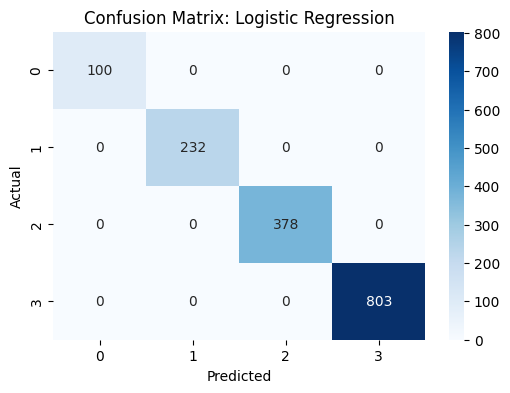

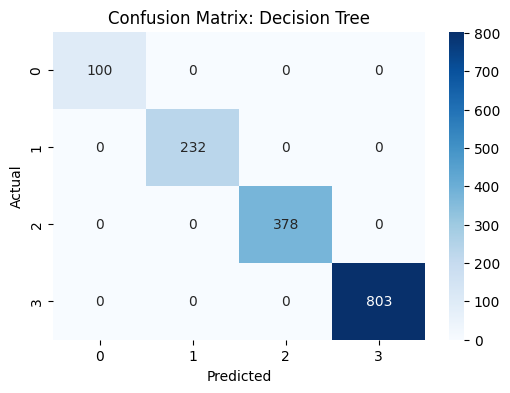

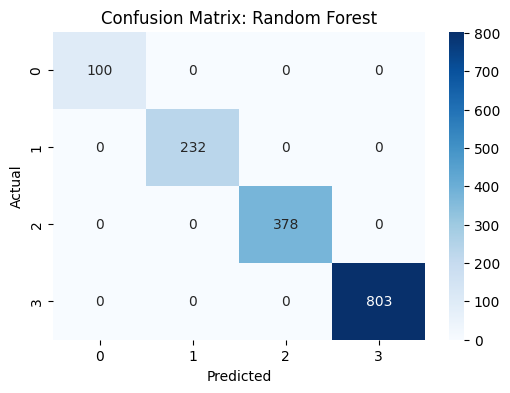

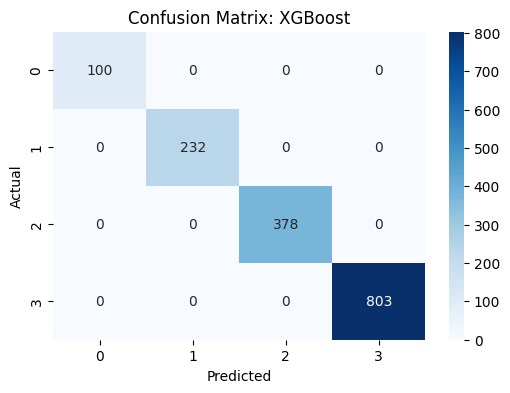

                 Model  Accuracy  F1 Score  Precision  Recall ROC AUC
0  Logistic Regression       1.0       1.0        1.0     1.0    None
1        Decision Tree       1.0       1.0        1.0     1.0    None
2        Random Forest       1.0       1.0        1.0     1.0    None
3              XGBoost       1.0       1.0        1.0     1.0    None


In [61]:
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.metrics import roc_auc_score, roc_curve, confusion_matrix, accuracy_score, f1_score, precision_score, recall_score
import seaborn as sns
import pandas as pd

import matplotlib.pyplot as plt

# Initialize the models
models = {
    'Logistic Regression': LogisticRegression(max_iter=1000, random_state=42),
    'Decision Tree': DecisionTreeClassifier(random_state=42),
    'Random Forest': RandomForestClassifier(random_state=42),
    'XGBoost': XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42)
}

# Fit the models and calculate metrics on the test set
results = []
for model_name, model in models.items():
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    
    # Check if the model has predict_proba method (for probabilistic classifiers)
    if hasattr(model, "predict_proba"):
        y_proba = model.predict_proba(X_test)
        if y_proba.shape[1] == 2:  # Binary classification case: select the probability of the positive class
            y_proba = y_proba[:, 1]
        else:  # If not binary, raise an error or handle appropriately
            y_proba = y_proba.max(axis=1)
    else:
        # If the model doesn't have predict_proba, use decision_function or handle accordingly
        if hasattr(model, "decision_function"):
            y_proba = model.decision_function(X_test)
        else:
            y_proba = y_pred  # Use predictions directly if probabilities are unavailable
    
    # Calculate metrics
    accuracy = accuracy_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred, average='weighted')
    precision = precision_score(y_test, y_pred, average='weighted')
    recall = recall_score(y_test, y_pred, average='weighted')
    
    # For ROC AUC, ensure binary classification
    if len(set(y_test)) == 2:
        roc_auc = roc_auc_score(y_test, y_proba)
    else:
        roc_auc = None  # Handle multiclass or raise a warning

    results.append({
        'Model': model_name,
        'Accuracy': accuracy,
        'F1 Score': f1,
        'Precision': precision,
        'Recall': recall,
        'ROC AUC': roc_auc
    })
    
    # Plot ROC-AUC curve if binary classification
    if roc_auc is not None:
        fpr, tpr, _ = roc_curve(y_test, y_proba)
        plt.plot(fpr, tpr, label=f'{model_name} (area = {roc_auc:.2f})')
    
    # Plot confusion matrix
    cm = confusion_matrix(y_test, y_pred)
    plt.figure(figsize=(6, 4))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.title(f'Confusion Matrix: {model_name}')
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.show()

# Plot ROC-AUC curve (for binary classification)
if roc_auc is not None:
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC-AUC Curve')
    plt.legend(loc='best')
    plt.show()

# Create a DataFrame with the results
results_df = pd.DataFrame(results)
print(results_df)

In [70]:
X_train_selected = X_train[selected_features]
X_val_selected = X_val[selected_features]
X_test_selected = X_test[selected_features]

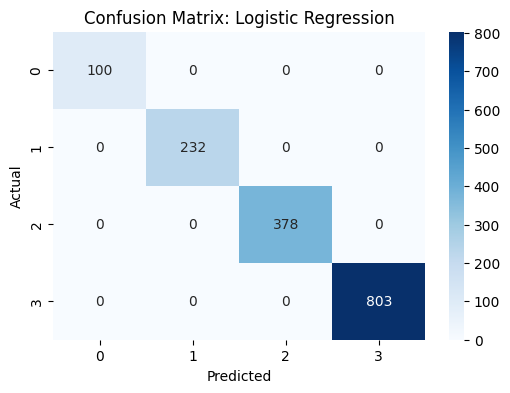

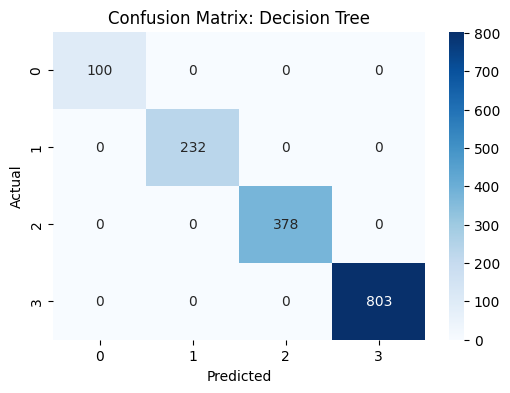

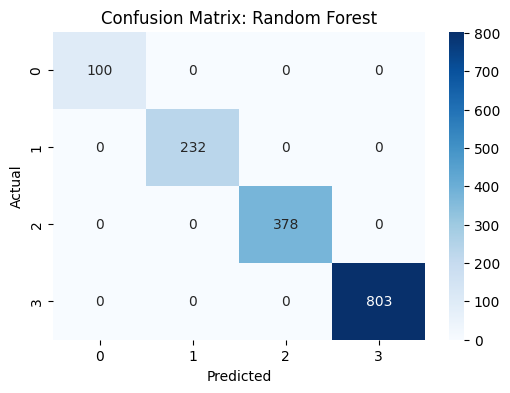

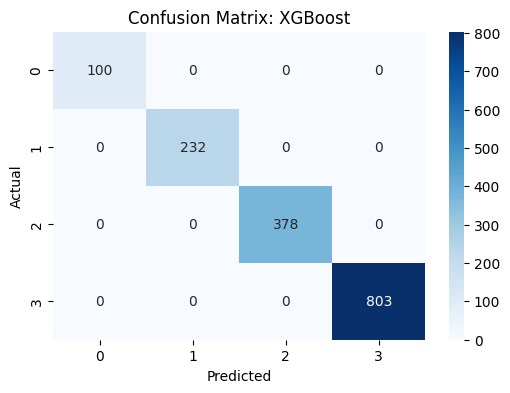

                 Model  Accuracy  F1 Score  Precision  Recall ROC AUC
0  Logistic Regression       1.0       1.0        1.0     1.0    None
1        Decision Tree       1.0       1.0        1.0     1.0    None
2        Random Forest       1.0       1.0        1.0     1.0    None
3              XGBoost       1.0       1.0        1.0     1.0    None


In [72]:
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.metrics import roc_auc_score, roc_curve, confusion_matrix, accuracy_score, f1_score, precision_score, recall_score
import seaborn as sns
import pandas as pd

import matplotlib.pyplot as plt

# Initialize the models
models = {
    'Logistic Regression': LogisticRegression(max_iter=1000, random_state=42),
    'Decision Tree': DecisionTreeClassifier(random_state=42),
    'Random Forest': RandomForestClassifier(random_state=42),
    'XGBoost': XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42)
}

# Fit the models and calculate metrics on the test set
results = []
for model_name, model in models.items():
    model.fit(X_train_selected, y_train)
    y_pred = model.predict(X_test_selected)
    
    # Check if the model has predict_proba method (for probabilistic classifiers)
    if hasattr(model, "predict_proba"):
        y_proba = model.predict_proba(X_test_selected)
        if y_proba.shape[1] == 2:  # Binary classification case: select the probability of the positive class
            y_proba = y_proba[:, 1]
        else:  # If not binary, raise an error or handle appropriately
            y_proba = y_proba.max(axis=1)
    else:
        # If the model doesn't have predict_proba, use decision_function or handle accordingly
        if hasattr(model, "decision_function"):
            y_proba = model.decision_function(X_test_selected)
        else:
            y_proba = y_pred  # Use predictions directly if probabilities are unavailable
    
    # Calculate metrics
    accuracy = accuracy_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred, average='weighted')
    precision = precision_score(y_test, y_pred, average='weighted')
    recall = recall_score(y_test, y_pred, average='weighted')
    
    # For ROC AUC, ensure binary classification
    if len(set(y_test)) == 2:
        roc_auc = roc_auc_score(y_test, y_proba)
    else:
        roc_auc = None  # Handle multiclass or raise a warning

    results.append({
        'Model': model_name,
        'Accuracy': accuracy,
        'F1 Score': f1,
        'Precision': precision,
        'Recall': recall,
        'ROC AUC': roc_auc
    })
    
    # Plot ROC-AUC curve if binary classification
    if roc_auc is not None:
        fpr, tpr, _ = roc_curve(y_test, y_proba)
        plt.plot(fpr, tpr, label=f'{model_name} (area = {roc_auc:.2f})')
    
    # Plot confusion matrix
    cm = confusion_matrix(y_test, y_pred)
    plt.figure(figsize=(6, 4))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.title(f'Confusion Matrix: {model_name}')
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.show()

# Plot ROC-AUC curve (for binary classification)
if roc_auc is not None:
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC-AUC Curve')
    plt.legend(loc='best')
    plt.show()

# Create a DataFrame with the results
results_df = pd.DataFrame(results)
print(results_df)

In [73]:
data_copy.shape

(50410, 29)

In [71]:
X_train_selected.head()

,country,country_psp_success_rate,uk_card_germany_successrate,uk_card_Austria_successrate,uk_card_swiz_successrate,simplecard_germany_successrate,simplecard_austria_successrate,simplecard_swiz_successrate,moneycard_germany_successrate,moneycard_swiz_successrate
19185,0,0.195451,0.000000,0.193926,0.000000,0.0,0.0,0.0,0.000000,0.0
45798,1,0.193926,0.193926,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.0
33882,1,0.394018,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.394018,0.0
31230,2,0.194486,0.000000,0.000000,0.193926,0.0,0.0,0.0,0.000000,0.0
42209,1,0.193926,0.193926,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.0
